In [74]:
from generator_model import Generator
from torch import optim
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from dataset import Image_dataset
import config
from tqdm import tqdm

gen = Generator(in_channels=3)
checkpoint = torch.load("gen.pth-3.tar", map_location=torch.device(config.DEVICE))
gen.load_state_dict(checkpoint['state_dict'])
optimizer = optim.Adam(gen.parameters())
optimizer.load_state_dict(checkpoint['optimizer'])

/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_55634/1969178341.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("gen.pth-3.tar", map

In [36]:
val_dataset = Image_dataset(root_dir="image_dataset/drones/val")
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [37]:
val_dataset = Image_dataset(root_dir="image_dataset/drones/train")
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

all = {"x": [], "z": [], "y": [], "y_fake": []}

# x, y = next(iter(val_loader))

per = 25
for idx, (x,z,y) in tqdm(enumerate(val_loader)):
    if idx == per: break
    x, z, y = x.to(config.DEVICE), z.to(config.DEVICE), y.to(config.DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x,z)
        y_fake = y_fake * 0.5 + 0.5
        y = y * 0.5 + 0.5
        x = x * 0.5 + 0.5
    all["x"].append(x)
    all["z"].append(z)
    all["y"].append(y)
    all["y_fake"].append(y_fake)
    

7it [00:00,  9.79it/s]


In [38]:
def convert(x):
    return np.moveaxis(np.array(x[0, :, :, :]), 0, -1)

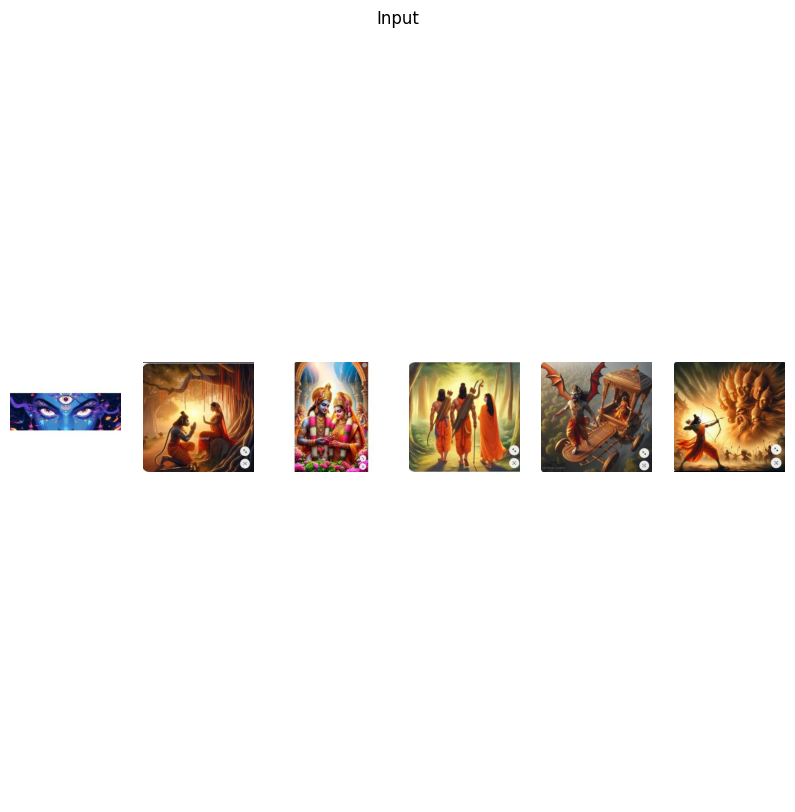

In [39]:
fig = plt.figure(figsize=(10, 10))
plt.title("Input")
plt.axis("off")
columns = 6
rows = 1
for i in range(1, columns*rows +1):
    img = convert(all['x'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")


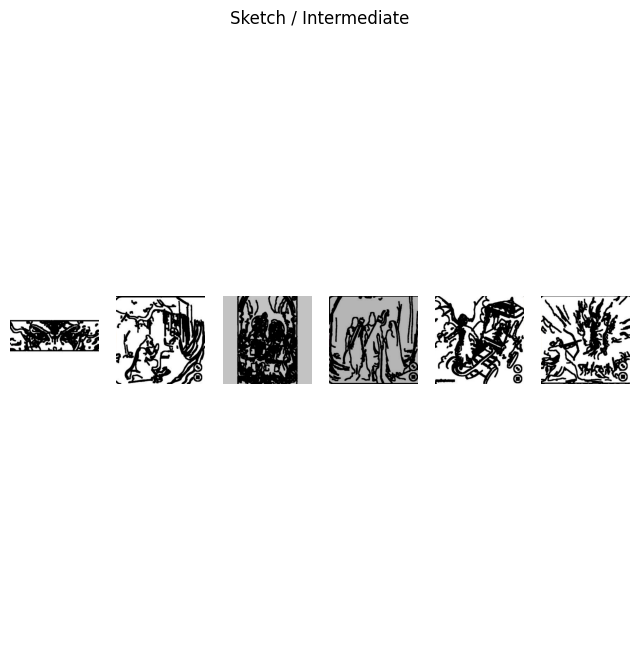

In [40]:
fig = plt.figure(figsize=(8, 8))
plt.title("Sketch / Intermediate")
plt.axis("off")

for i in range(1, columns*rows +1):
    img = convert(all['z'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.clip(0,1))
    plt.axis("off")


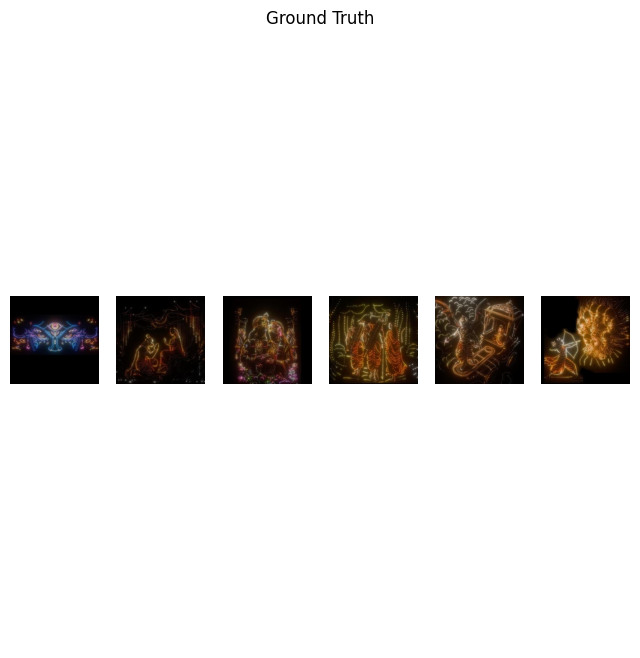

In [41]:
fig = plt.figure(figsize=(8, 8))

plt.title("Ground Truth")
plt.axis("off")

for i in range(1, columns*rows +1):
    img = convert(all['y'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.clip(0,1))
    plt.axis("off")


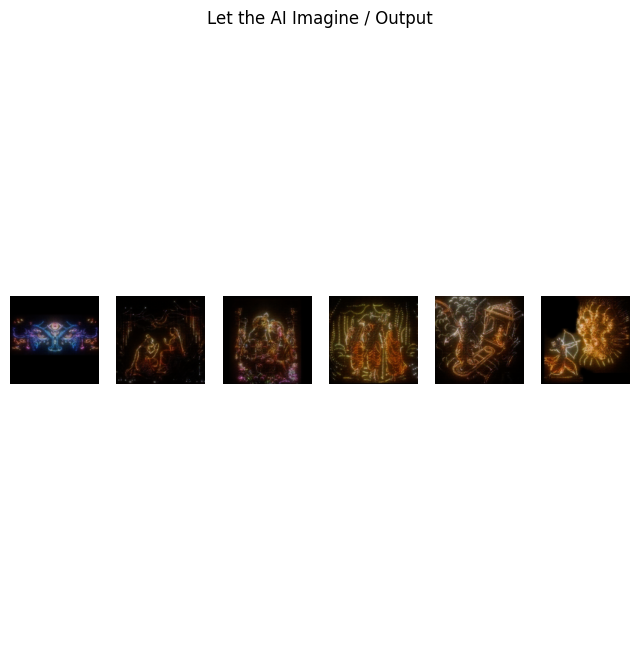

In [42]:
fig = plt.figure(figsize=(8, 8))

plt.title("Let the AI Imagine / Output")
plt.axis("off")

for i in range(1, columns*rows +1):
    img = convert(all['y_fake'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")

In [46]:
image_pth = "image_dataset/drones/val/3.jpg"
image = np.array(Image.open(image_pth))
image_x = image[:, :256, ...]
image_z = image[:, 256:256*2, ...]
x = config.transform_only_input(image=image_x)["image"]
z = config.transform_only_inter(image=image_z)["image"]

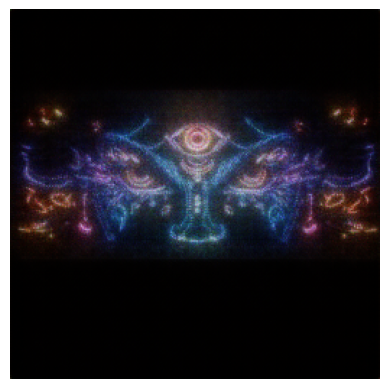

In [47]:
generated_image_self = gen(x.unsqueeze(0) ,z.unsqueeze(0)) * 0.5 + 0.5
generated_image_self = generated_image_self[0].permute(1,2,0).detach().numpy()

plt.imshow(generated_image_self)
plt.axis("off")
plt.imsave("Drone_output_self.jpg", generated_image_self)
plt.show() 

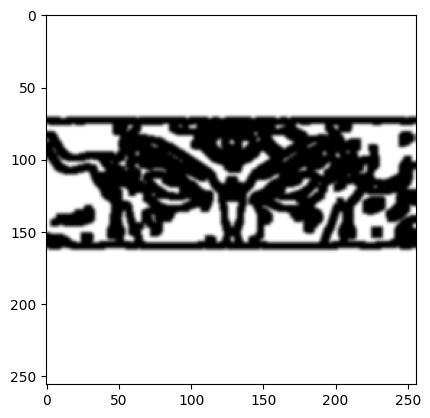

In [30]:
import utils
image_z_self = utils.image_to_line_art(image_x, thickenss=5)
z_self = config.transform_only_inter(image=image_z_self)["image"]
z_true_sefl = config.transform_only_inter(image=image_z)["image"]
plt.imshow(image_z_self)
plt.show() 

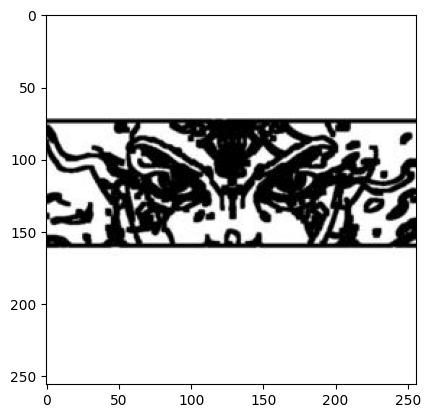

In [39]:
plt.imshow(image_z)

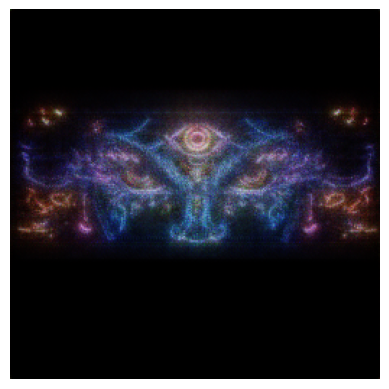

In [40]:
generated_image_self = gen(x.unsqueeze(0) ,z_self.unsqueeze(0)) * 0.5 + 0.5
generated_image_self = generated_image_self[0].permute(1,2,0).detach().numpy()

plt.imshow(generated_image_self)
plt.axis("off")
plt.imsave("Drone_output_self.jpg", generated_image_self)

In [41]:
import utils
image_z_self_empty = np.zeros_like(image_z)
z_self_empty = config.transform_only_input(image=image_z_self_empty)["image"]

In [42]:
generated_image = gen(x.unsqueeze(0) ,z.unsqueeze(0)) * 0.5 + 0.5
generated_image = generated_image[0].permute(1,2,0).detach().numpy()

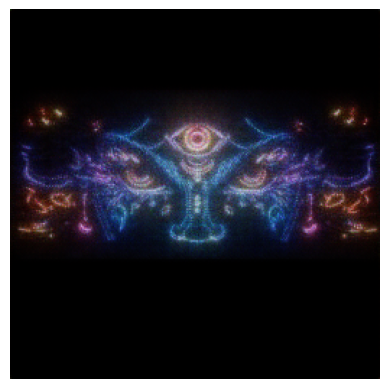

In [43]:
plt.imshow(generated_image)
plt.axis("off")
plt.imsave("Drone_output.jpg", generated_image)

In [44]:
generated_image_self_empty = gen(x.unsqueeze(0) ,z_self_empty.unsqueeze(0)) * 0.5 + 0.5
generated_image_self_empty = generated_image_self_empty[0].permute(1,2,0).detach().numpy()

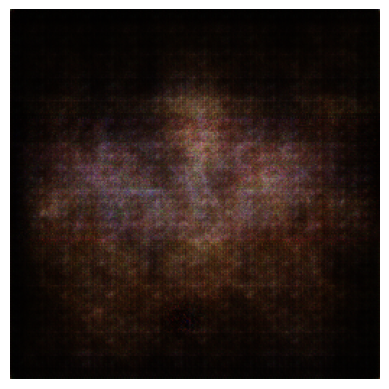

In [45]:
plt.imshow(generated_image_self_empty)
plt.axis("off")
plt.imsave("Drone_output_self_empty.jpg", generated_image_self_empty)

In [72]:
a = plt.imread("/Users/mohamedmafaz/PixSketch2Pix/image_dataset/drones/train/3.jpg")
a = a[:, :256, :]
plt.imsave("eyes_test.jpg", a)

In [78]:
import gradio as gr
import config
import utils
import cv2

def show_image(img):
    # image_x = img[:, :256, ...]
    # image_z = img[:, 256:256*2, ...]
    # image_x = img
    image_x = img

    x = config.transform_only_input(image=image_x)["image"]
    image_z = utils.image_to_line_art(image_x, thickenss=3)
    image_z = cv2.resize(image_z, (config.IMAGE_SIZE, config.IMAGE_SIZE))

    z = config.transform_only_inter(image=image_z)["image"]
    generated = gen(x.unsqueeze(0), z.unsqueeze(0)) * 0.5 + 0.5
    generated = generated[0].permute(1, 2, 0).cpu().detach().numpy()
    
    return image_z, generated

app = gr.Interface(
    fn=show_image,
    inputs=gr.Image(label="Input Image Component"),  # Defaults to numpy.array
    outputs=[
        gr.Image(label="Output Image 1"),
        gr.Image(label="Output Image 2")
    ],
)

app.launch()

Running on local URL:  http://127.0.0.1:7900

To create a public link, set `share=True` in `launch()`.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gradio/analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.37.2, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(


(-0.5, 255.5, 255.5, -0.5)

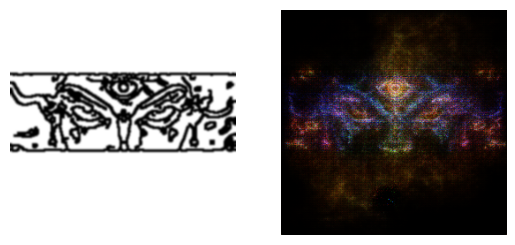

In [88]:

image_x = plt.imread("eyes_test.jpg")
x = config.transform_only_input(image=image_x)["image"]
image_z = utils.image_to_line_art(image_x, thickenss=3)
image_z = cv2.resize(image_z, (config.IMAGE_SIZE, config.IMAGE_SIZE))

z = config.transform_only_inter(image=image_z)["image"]
generated = gen(x.unsqueeze(0), z.unsqueeze(0)) * 0.5 + 0.5
generated = generated[0].permute(1, 2, 0).cpu().detach().numpy()

plt.subplot(1,2,1)
plt.imshow(image_z)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(generated)
plt.axis("off")

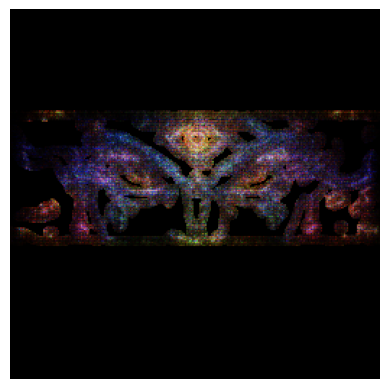

In [132]:
threshold = 249

black_mask = np.all(image_z <= threshold, axis=-1)
masked_image = np.zeros_like(generated)
masked_image[black_mask] = generated[black_mask]
plt.imshow(masked_image)
# plt.imshow(black_mask)
plt.axis("off")
plt.show()

In [19]:
import numpy as np
from PIL import Image
from utils import image_to_line_art
import cv2
import matplotlib.pyplot as plt

threshold = 249

input = np.array(Image.open("image_dataset/drones_600/train/1.jpg"))[:, :600, ...]
input_resized = cv2.resize(input, (600, 600))
line_art_resized = cv2.resize(image_to_line_art(input), (600, 600))
black_mask = np.all(line_art_resized <= threshold, axis=-1)
masked_image = np.zeros_like(input_resized)
masked_image[black_mask] = input_resized[black_mask]

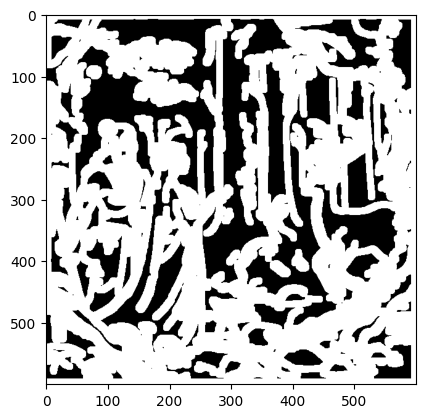

In [21]:
plt.imshow(black_mask, cmap="gray")

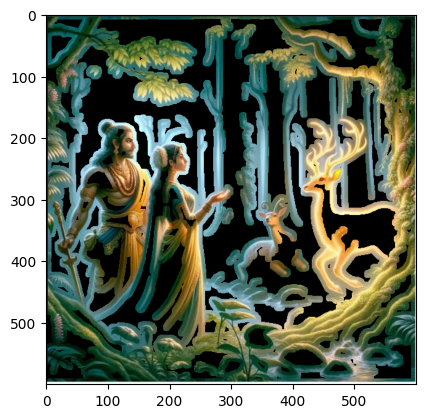

In [20]:
plt.imshow(masked_image)